## Data set - LTI system
An LTI system is excited by an uniform signal $X \sim U[-1, 1]$

In [56]:
from volterra import *

# system parameters
sys_imp_resp_length = 20
sys_impulse_response = np.linspace(10, 0.5, sys_imp_resp_length)
sys_impulse_response = [1] * sys_imp_resp_length
true_sys = LTISystem(sys_impulse_response)

# noise signal parameters
z_sigma = 0.1

x_amp = 1

# generate learning batch
est_batch_size = 1000
x_est = np.random.uniform(-x_amp, x_amp, est_batch_size)
z_est = z_sigma * np.random.standard_normal(est_batch_size)
y_est = true_sys.evaluate_output(x_est) + z_est

# generate validation batch
val_batch_size = 1000
x_val = np.random.uniform(-x_amp, x_amp, val_batch_size)
z_val = z_sigma * np.random.standard_normal(val_batch_size)
y_val = true_sys.evaluate_output(x_val) + z_val

## Aggregation algorithm

The algorithm aims to estimate Volterra model's parameters on an $\ell_1$-ball of radius $R$. 
Since, we know the $\ell_1$-norm of the true system's parameters we can choose optimal $R$.  

In [55]:
from aggregation import *
import matplotlib.pyplot as plt

# model parameters
model_order = 1
model_memory_len = sys_imp_resp_length
m = VolterraModel(model_order, model_memory_len)

params = aggregation_for_volterra(m.dictionary, x_est, y_est, R=np.linalg.norm(sys_impulse_response, 1))
m.set_parameters(params)

y_aggr = m.evaluate_output(x_val)

# plot data
plt.rcParams['figure.dpi'] = 150
plt.plot(y_aggr[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

## Entropic descent on a probabilistic simplex

To use this method we need following parameters:
- $\sigma_Z^2$ - variance of the noise signal
- $R$ - radius of the $\ell_1$-ball over which we estimate
- $M$ - the system's output magnitude

We also use a _scaling parameter_ that scales the stepsize - apparently the equation for its derivation doesn't work

In [ ]:
from entropic_descent import *

z_var = z_sigma ** 2
R = np.linalg.norm(sys_impulse_response, 1)
M = np.max(np.abs(x_est))

# model parameters
model_order = 1
model_memory_len = sys_imp_resp_length

include_constant_function = False
m = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function)
D = m.dictionary.size

G_sq = R ** 2 * ((R + M) ** 2 + z_var)

scaling_parameter = 10  # this is parameter for scaling the stepsize

stepsize = scaling_parameter * np.sqrt(2 * np.log(D) / (G_sq * (est_batch_size + 1)))
stepsize_function = lambda i: stepsize

# FIXME copy doesnt work, dictionary instead of m.dictionary
dictionary = VolterraDictionary(model_order, model_memory_len, include_constant_function=include_constant_function)
alg = EntropicDescentAlgorithm(dictionary, R=R, constraint='simplex')
model_parameters = alg.run(x_est, y_est, stepsize_function)

m.set_parameters(model_parameters)
                   
y_ed = m.evaluate_output(x_val)

# plot data
plt.rcParams['figure.dpi'] = 150
plt.plot(y_ed[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()


In [ ]:
x = [1] + [0] * 10
plt.rcParams['figure.dpi'] = 150
plt.plot(m.evaluate_output(x), 'bo')
plt.plot(true_sys.evaluate_output(x), 'ro')
plt.xlabel('t')
plt.ylabel('impulse response')
plt.legend(['model', 'true system'])
plt.show()


## Data set - LTI system with negative impulse response values
An LTI system is excited by an uniform signal $X \sim U[-1, 1]$

In [11]:
from volterra import *

# system parameters
sys_imp_resp_length = 15
sys_impulse_response = np.linspace(5, -5, sys_imp_resp_length)
true_sys = LTISystem(sys_impulse_response)

# noise signal parameters
z_sigma = 0.001

# generate learning batch
est_batch_size = 100000
x_est = np.random.uniform(-1, 1, est_batch_size)
z_est = z_sigma * np.random.standard_normal(est_batch_size)
y_est = true_sys.evaluate_output(x_est) + z_est

# generate validation batch
val_batch_size = 1000
x_val = np.random.uniform(-1, 1, val_batch_size)
z_val = z_sigma * np.random.standard_normal(val_batch_size)
y_val = true_sys.evaluate_output(x_val) + z_val

# Entropic descent on an $\ell_1$-ball

         Empirical loss: 5.49328314261388
Theoretical upper bound: 40.90967460181213


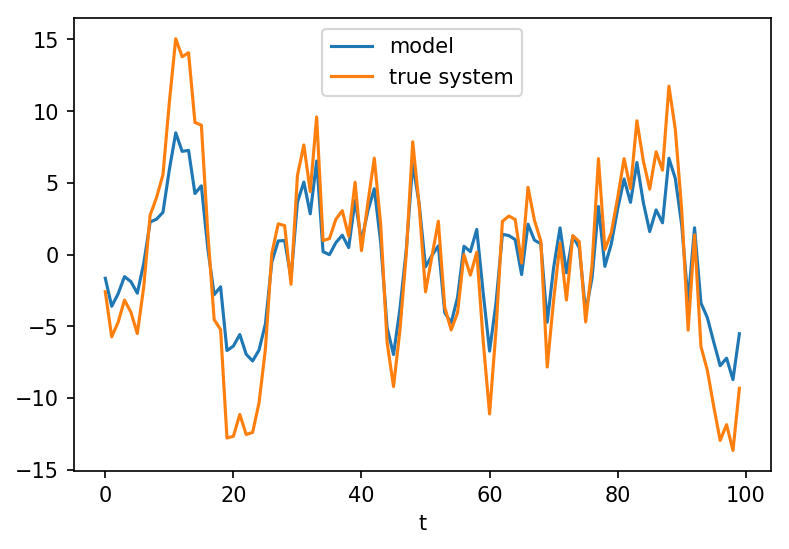

In [15]:
from entropic_descent import *

z_var = z_sigma ** 2
R = np.linalg.norm(sys_impulse_response, 1)
M = R #np.max(np.abs(x_est))

# model parameters
model_order = 3
model_memory_len = sys_imp_resp_length + 5

include_constant_function = False
m = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function)
D = m.dictionary.size

G_sq = R ** 2 * ((R + M) ** 2 + z_var)

scaling_parameter = 1  # this is parameter for scaling the stepsize

stepsize = scaling_parameter * np.sqrt(2 * np.log(2 * D) / (G_sq * (est_batch_size + 1)))
stepsize_function = lambda i: stepsize

# FIXME copy doesnt work, dictionary instead of m.dictionary
dictionary = VolterraDictionary(model_order, model_memory_len, include_constant_function=include_constant_function)
alg = EntropicDescentAlgorithm(dictionary, R=R, constraint='ball')
model_parameters = alg.run(x_est, y_est, stepsize_function)

m.set_parameters(model_parameters)
                   
y_ed = m.evaluate_output(x_val)

loss = 0.5 * np.mean(np.square(y_val - y_ed))
loss_upper_bound = np.sqrt(G_sq * 2 * np.log(2 * D) / est_batch_size) + 0.5 * z_var
print("         Empirical loss: {0}".format(loss))
print("Theoretical upper bound: {0}".format(loss_upper_bound))

# plot data
plt.rcParams['figure.dpi'] = 150
plt.plot(y_ed[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()


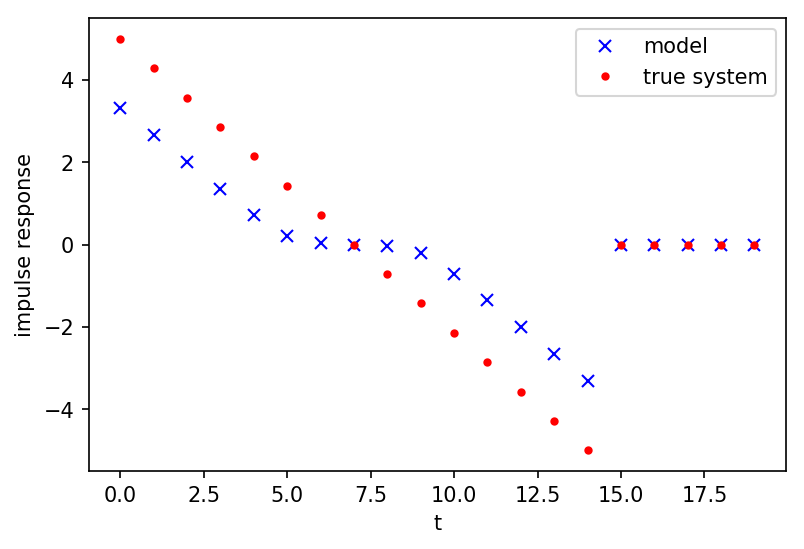

In [16]:
x = [1] + [0] * (sys_imp_resp_length + 4)
plt.rcParams['figure.dpi'] = 150
plt.plot(m.evaluate_output(x), 'bx')
plt.plot(true_sys.evaluate_output(x), 'r.')
plt.xlabel('t')
plt.ylabel('impulse response')
plt.legend(['model', 'true system'])
plt.show()


           Average loss: 202.12730054770435
Theoretical upper bound: 4251.390561074599


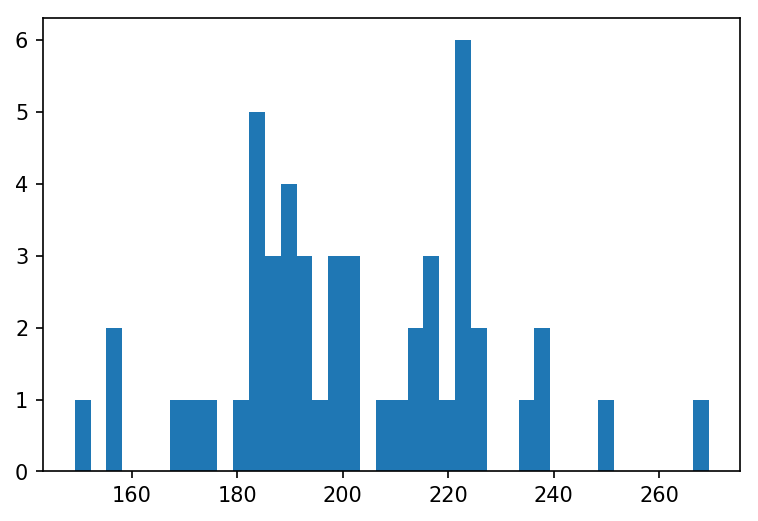

In [16]:
num_of_experiments = 50

x_amp = 1
est_batch_size = 1000
val_batch_size = 1000

avg_mse_in_experiment = np.zeros(num_of_experiments)

for i in range(num_of_experiments):
    # generate learning batch
    x_est = np.random.uniform(-x_amp, x_amp, est_batch_size)
    z_est = z_sigma * np.random.standard_normal(est_batch_size)
    y_est = true_sys.evaluate_output(x_est) + z_est

    # generate validation batch
    x_val = np.random.uniform(-x_amp, x_amp, val_batch_size)
    z_val = z_sigma * np.random.standard_normal(val_batch_size)
    y_val = true_sys.evaluate_output(x_val) + z_val

    m = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function)
    dictionary = VolterraDictionary(model_order, model_memory_len, include_constant_function=include_constant_function)
    alg = EntropicDescentAlgorithm(dictionary, R=R, constraint='ball')
    model_parameters = alg.run(x_est, y_est, stepsize_function)
    m.set_parameters(model_parameters)
    
    y_ed = m.evaluate_output(x_val)
    
    avg_mse_in_experiment[i] = 0.5 * np.mean(np.square(y_val - y_ed))
    
    
avg_loss = np.average(avg_mse_in_experiment)
avg_loss_upper_bound = np.sqrt(G_sq * 2 * np.log(2 * D) / est_batch_size) + 0.5 * z_var
print("           Average loss: {0}".format(avg_loss))
print("Theoretical upper bound: {0}".format(avg_loss_upper_bound))

plt.hist(avg_mse_in_experiment, bins=40)
plt.show()